In [39]:
import random
import sys
sys.path.insert(0,'C:\\code\\masters_thesis\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import requests
import random
import bs4 as bs
import datetime
import yfinance as yf
# from pandas_datareader import data as pdr
# from pandas_datareader.data import DataReader
from pandas_datareader.yahoo.daily import YahooDailyReader
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import minimize

"""
Own packages
"""

# from codelib.statistics.moments import corr_to_cov_matrix
from codelib.population_parameters import beregn_middelvaerdi, beregn_kovarians_mat, calculate_variance
from codelib.portfolio_measures import portfolio_mean, portfolio_variance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# udvælg population af 20 tilfældige aktiver (her fra S&P500)
# hent 313 observationer af månedligt afkast for disse aktiver
# beregn populationens vektor af middelværdier og kovarians matrice
# Check om vi kan antage at disse observationer er multivariat normalfordelte?
# Brug populationsparametrene til at simulere 1000 trækninger af multivariate normalfordelte værdier med t=60, 100, 300, 500, 1000
# beregn optimal parametre for: forventet afkast, portefølje varians og porteføljevægte (for hver af de 1000 trækninger)
# beregn middelværdi og varians for disse parametre over de 500 trækninger.
# sammenlign/beregn sharpe-ratio af:
# (1) gennemsnittet af de simulerede optimale porteføljer,
# (2) den optimale porteøfølje beregnet fra den "kendte" multivariate normalfordeling
# (3) en lige-vægtet portefølje af de 20 aktiver.

In [2]:
# get wikipedia table containing S&P 500 tickers
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

# get S&P500 tickers and remove \n
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)
tickers = [s.replace('\n', '') for s in tickers]

In [3]:
# choose 20 tickers randomly
random.seed(1)
random_tickers = random.choices(tickers, k=20)
print(random_tickers)

['TECH', 'SBUX', 'PRU', 'CPRT', 'ILMN', 'HIG', 'MS', 'O', 'ACGL', 'AKAM', 'SJM', 'GE', 'PLD', 'AOS', 'GS', 'PARA', 'CME', 'VICI', 'TRV', 'ALK']


In [4]:
# choose ticker without missing values for timeframe
chosen_tickers = ['ACGL','ADM','AIG','ALK','AOS','BSX','CL','CPRT','EXC','GE','HD','HIG','HST','JBHT','KO','MAS','MGM','SJM','SNA','TROW']

In [7]:
# get 'adjusted close' stock prices from 20 random stocks in S&P500
start = datetime.date(1996, 1, 1)
end = datetime.date(2022, 1, 2)
SP500_adj_close = yf.download(chosen_tickers, start=start, end=end, interval='1mo')['Close']

[*********************100%***********************]  20 of 20 completed


In [8]:
SP500_adj_close

,ACGL,ADM,AIG,ALK,AOS,BSX,CL,CPRT,EXC,GE,HD,HIG,HST,JBHT,KO,MAS,MGM,SJM,SNA,TROW
Date,,,,,,,,,,,,,,,,,,,,
1996-01-01 00:00:00-05:00,2.263889,14.178093,459.259247,4.937500,2.791667,12.812500,9.250000,0.619792,10.966476,76.812988,10.222222,25.062500,11.257954,3.906250,18.843750,12.851494,7.375000,20.750000,29.333332,6.750000
1996-02-01 00:00:00-05:00,2.250000,14.364646,459.259247,5.562500,2.694444,12.000000,9.781250,0.583333,10.074893,75.561958,9.611111,25.750000,12.726383,4.562500,20.187500,12.521968,8.312500,20.125000,29.833332,6.718750
1996-03-01 00:00:00-05:00,2.277778,13.711708,443.851837,6.687500,2.625000,11.500000,9.734375,0.515625,9.495364,77.938911,10.611111,24.500000,13.215859,4.937500,20.687500,12.741652,9.593750,22.250000,31.166668,6.625000
1996-04-01 00:00:00-05:00,2.208333,14.084816,433.185181,6.375000,2.555556,10.781250,9.578125,0.567708,8.826676,77.313400,10.527778,24.187500,13.093490,5.093750,20.375000,11.972759,10.906250,21.125000,32.000000,6.968750
1996-05-01 00:00:00-04:00,2.194444,14.551200,446.814819,6.500000,2.972222,10.718750,9.843750,0.354167,8.782097,82.817909,11.361111,25.875000,12.848752,4.750000,23.000000,13.730228,11.375000,20.375000,32.083332,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01 00:00:00-04:00,38.180000,60.009998,54.889999,58.599998,61.070000,43.389999,75.580002,69.360001,34.479317,80.429352,328.260010,70.250000,16.330000,167.220001,52.470001,55.549999,43.150002,120.029999,208.949997,196.699997
2021-10-01 00:00:00-04:00,41.820000,64.239998,59.090000,52.799999,73.070000,43.130001,76.190002,77.644997,37.938660,81.865730,371.739990,72.930000,16.830000,197.190002,56.369999,65.550003,47.160000,122.860001,203.229996,216.880005
2021-11-01 00:00:00-04:00,40.380001,62.209999,52.599998,48.570000,79.050003,38.070000,75.019997,72.580002,37.610558,74.153008,400.609985,66.099998,15.700000,191.160004,52.450001,65.900002,39.580002,126.470001,205.910004,199.949997


In [9]:
SP500_adj_close.index = pd.to_datetime(SP500_adj_close.index.date)

In [10]:
SP500_adj_close.head()

,ACGL,ADM,AIG,ALK,AOS,BSX,CL,CPRT,EXC,GE,HD,HIG,HST,JBHT,KO,MAS,MGM,SJM,SNA,TROW
1996-01-01,2.263889,14.178093,459.259247,4.9375,2.791667,12.81250,9.250000,0.619792,10.966476,76.812988,10.222222,25.0625,11.257954,3.90625,18.84375,12.851494,7.37500,20.750,29.333332,6.75000
1996-02-01,2.250000,14.364646,459.259247,5.5625,2.694444,12.00000,9.781250,0.583333,10.074893,75.561958,9.611111,25.7500,12.726383,4.56250,20.18750,12.521968,8.31250,20.125,29.833332,6.71875
1996-03-01,2.277778,13.711708,443.851837,6.6875,2.625000,11.50000,9.734375,0.515625,9.495364,77.938911,10.611111,24.5000,13.215859,4.93750,20.68750,12.741652,9.59375,22.250,31.166668,6.62500
1996-04-01,2.208333,14.084816,433.185181,6.3750,2.555556,10.78125,9.578125,0.567708,8.826676,77.313400,10.527778,24.1875,13.093490,5.09375,20.37500,11.972759,10.90625,21.125,32.000000,6.96875
1996-05-01,2.194444,14.551200,446.814819,6.5000,2.972222,10.71875,9.843750,0.354167,8.782097,82.817909,11.361111,25.8750,12.848752,4.75000,23.00000,13.730228,11.37500,20.375,32.083332,7.00000


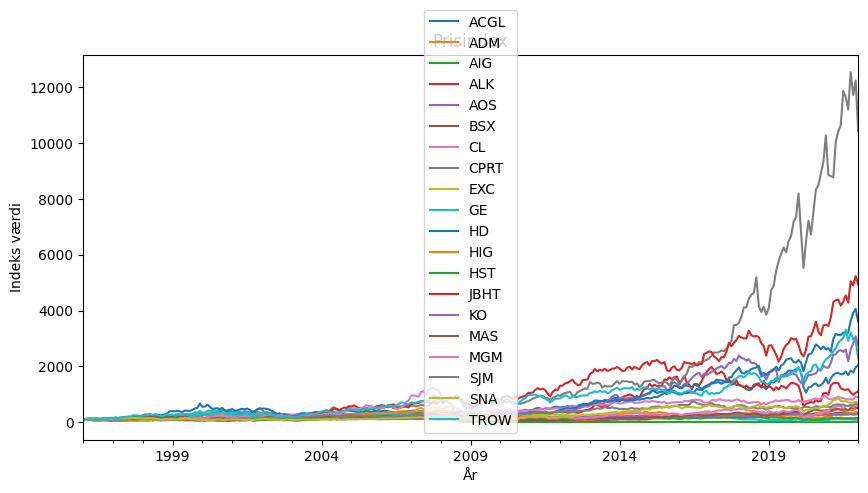

In [11]:
# visualize price index evolution
df = SP500_adj_close
df = df / df.iloc[0, :] * 100 # normalize base year

ax = df.plot(title="Prisindex", figsize=(10, 5), xlabel="År");
ax.set_ylabel('Indeks værdi');

In [12]:
# calculate monthly returns
SP500_monthly_returns = ((SP500_adj_close / SP500_adj_close.shift(1) - 1) * 100).dropna()
SP500_monthly_returns

,ACGL,ADM,AIG,ALK,AOS,BSX,CL,CPRT,EXC,GE,HD,HIG,HST,JBHT,KO,MAS,MGM,SJM,SNA,TROW
1996-02-01,-0.613505,1.315783,0.000000,12.658228,-3.482616,-6.341463,5.743243,-5.882453,-8.130081,-1.628670,-5.978266,2.743142,13.043486,16.800000,7.131012,-2.564106,12.711864,-3.012048,1.704546,-0.462963
1996-03-01,1.234574,-4.545451,-3.354839,20.224719,-2.577301,-4.166667,-0.479233,-11.607095,-5.752208,3.145701,10.404625,-4.854369,3.846153,8.219178,2.476780,1.754386,15.413534,10.559006,4.469282,-1.395349
1996-04-01,-3.048800,2.721090,-2.403202,-4.672897,-2.645483,-6.250000,-1.605136,10.100948,-7.042256,-0.802566,-0.785337,-1.275510,-0.925931,3.164557,-1.510574,-6.034479,13.680782,-5.056180,2.673793,5.188679
1996-05-01,-0.628939,3.311253,3.146377,1.960784,16.304320,-0.579710,2.773246,-37.614583,-0.505054,7.119735,7.915564,6.976744,-1.869155,-6.748466,12.883436,14.678898,4.297994,-3.550296,0.260413,0.448430
1996-06-01,-0.632866,-1.923078,4.641906,5.288462,-6.542047,4.956268,7.619048,-2.941272,5.583755,4.833834,5.623476,2.898551,-0.952379,9.868421,6.521739,-3.200000,-12.362637,-3.680982,-1.558442,9.821429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,-7.104619,0.016664,0.604835,2.197416,-16.020354,-3.898122,-3.040404,-3.880270,-1.387184,-2.257853,0.637690,4.507585,-1.388886,-5.738440,-6.819393,-8.514496,1.243554,-2.943316,-7.112692,-12.136507
2021-10-01,9.533786,7.048825,7.651668,-9.897610,19.649583,-0.599213,0.807093,11.944919,10.033096,1.785888,13.245592,3.814947,3.061849,17.922498,7.432814,18.001807,9.293159,2.357745,-2.737498,10.259282
2021-11-01,-3.443325,-3.160023,-10.983249,-8.011363,8.183938,-11.731976,-1.535642,-6.523273,-0.864823,-9.421186,7.766180,-9.365147,-6.714202,-3.057964,-6.954050,0.533941,-16.072939,2.938304,1.318707,-7.806164
2021-12-01,10.079246,8.648123,8.098864,7.267858,8.602144,11.583924,13.756332,4.450256,9.539158,-0.547432,3.594525,4.447810,10.764329,6.926130,12.888462,6.555386,13.390599,7.393062,4.599097,-1.655413


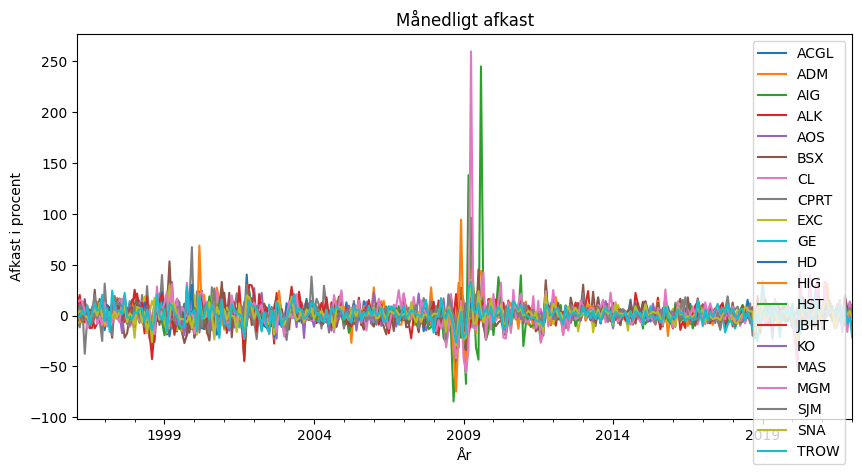

In [13]:
# plot monthly returns
ax = SP500_monthly_returns.plot(title="Månedligt afkast", figsize=(10, 5), xlabel="År");
ax.set_ylabel('Afkast i procent');

In [14]:
# calculate population parameters: mean returns and covariance matrix og returns
# m = beregn_middelvaerdi(SP500_monthly_returns,axis=0) # med min funktion

mean_returns = np.mean(SP500_monthly_returns, axis=0)
print(mean_returns)
cov_mat_returns = np.cov(SP500_monthly_returns.T) #normalized by N-1 by default
print(cov_mat_returns)

ACGL    1.160933
ADM     0.836220
AIG     0.899096
ALK     1.357223
AOS     1.485104
BSX     0.905146
CL      0.883656
CPRT    2.082749
EXC     0.638259
GE      0.342385
HD      1.427074
HIG     1.184437
HST     0.663000
JBHT    1.726204
KO      0.551259
MAS     1.004881
MGM     1.916809
SJM     0.817315
SNA     0.963781
TROW    1.360509
dtype: float64
[[ 37.99203543  10.10543429  18.83501514  18.74216399  11.12011542
    2.69878356   1.98395028   1.21058877   4.09690447  12.30945901
    7.87710208  18.26109401  17.29037716  13.07101094   8.03586567
   15.59854988  23.56658195   9.79217278  17.11302462  13.11148157]
 [ 10.10543429  61.08938739  18.56795003  18.23656398  13.13551018
    4.32201564  10.4129397   11.90123813   8.84187957   9.0952886
    4.79642125  19.04504449  11.07107386  14.74415948  12.58334035
   17.5295773    3.34535534   9.15268119  17.57398977  16.26386114]
 [ 18.83501514  18.56795003 392.0254607   23.45054777  15.08826287
   38.15244699  19.28606717  27.42648309 

In [198]:
# data2 = data.dropna(axis=1)
# data2

In [199]:
# SP500_adj_close = data2.sample(random_state = 2, n=20,axis='columns')

In [200]:
# SP500_linear_returns = ((SP500_adj_close / SP500_adj_close.shift(1) - 1) * 100).dropna()

In [15]:
"""
VIRKER IKKE MED YahooDailerReader
"""
# get adjusted close stock prices from all stocks in S&P500
start = datetime.date(2020, 1, 1)
end = datetime.date(2022, 1, 1)
SP500 = YahooDailyReader(tickers, start = start)

In [16]:
SP500.read()

TypeError: string indices must be integers

In [18]:
# sharpe-raatio function
def sharpe_ratio(x, mu, cov_mat):  # læg denne funktion i codelib og gør den færdig
  return - (portfolio_mean(x, mu) / np.sqrt(portfolio_variance(x, cov_mat)))

In [24]:
# find maximum sharpe-ratio portfolio (tangency portfolio):
def sharpe_ratio(x, mu, cov_mat):  # læg denne funktion i codelib og gør den færdig
  return - (portfolio_mean(x, mu) / np.sqrt(portfolio_variance(x, cov_mat)))

x = np.empty(len(chosen_tickers))  # ikke behov for denne, kun til bounds, kan laves på en anden måde..

# budget begrænsning
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
# long-only begrænsning
bounds = tuple((0, 1) for j in x)
# initialværdi for vektor af portefølje vægte
equal_weights = np.array([1 / len(chosen_tickers)] * len(chosen_tickers))

# minimeringsproblem:
max_sharpe_results = minimize(
  # Objective function
  fun = sharpe_ratio, args=(mean_returns, cov_mat_returns,),
  # Initial guess, which is the equal weight array
  x0 = equal_weights,
  method = 'SLSQP',
  bounds = bounds,
  constraints = constraints)

w_opt = max_sharpe_results.x
print(np.round(w_opt,4))

[0.2812 0.0145 0.     0.     0.0996 0.0041 0.1081 0.1444 0.0964 0.
 0.1184 0.     0.     0.077  0.     0.     0.     0.0563 0.     0.    ]


In [25]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1, 'jac' : lambda x: np.ones_like(x)},
               {'type': 'ineq', 'fun' : lambda x: x, 'jac' : lambda x: np.eye(len(x))})
equal_weights = np.ones_like(mean_returns) / len(mean_returns)

res = minimize(fun = sharpe_ratio, args=(mean_returns, cov_mat_returns,),
               x0 = equal_weights,
               method = 'SLSQP',
               constraints = constraints,
               options={'ftol': 1e-9, 'disp': True})
w_m = res.x
print(np.round(w_m,4))

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.314389352412498
            Iterations: 10
            Function evaluations: 210
            Gradient evaluations: 10
[ 0.2812  0.0144  0.     -0.      0.0995  0.0041  0.1082  0.1446  0.0963
 -0.      0.1183  0.      0.      0.0769 -0.     -0.      0.      0.0564
  0.      0.    ]


In [30]:
# simulate  for (num_obs) t=60, 100, 300, 500, 1000 months
# find optimal portfolio weights/max sharpe for each simulation (1000 in total)

num_sim = 1000
num_obs = 500 # months
sim_data = np.random.multivariate_normal(mean_returns, cov_mat_returns, size=(num_sim, num_obs))

mu_est = np.mean(sim_data, axis=1)
opt_port_weights = list()

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1, 'jac' : lambda x: np.ones_like(x)},
               {'type': 'ineq', 'fun' : lambda x: x, 'jac' : lambda x: np.eye(len(x))})
equal_weights = np.ones_like(mean_returns) / len(mean_returns)

for i in range(num_sim):

    cov_mat_est = np.cov(sim_data[i], rowvar=False)

    res = minimize(fun = sharpe_ratio, args=(mu_est[i], cov_mat_est,),
                   x0 = equal_weights,
                   method = 'SLSQP',
                   constraints = constraints)
    opt_port_weights.append(res.x)

opt_port_weights = np.array(opt_port_weights)

In [32]:
np.mean(sim_data, axis=1)

array([[1.1502213 , 0.97719018, 0.28491515, ..., 0.94500695, 0.98912216,
        1.44781515],
       [1.02097435, 0.61113832, 0.05428565, ..., 1.03033107, 0.88570874,
        0.69710262],
       [1.02353279, 0.52998577, 2.02322838, ..., 1.1737664 , 1.15162004,
        1.43924598],
       ...,
       [1.12038345, 0.13599384, 1.78522633, ..., 0.42633785, 0.6763553 ,
        0.78987272],
       [1.1608832 , 0.17123365, 2.16805447, ..., 0.69972364, 0.8116264 ,
        2.01137368],
       [1.65403236, 1.10013587, 1.48031   , ..., 0.89479595, 0.76137329,
        1.39258937]])

In [31]:
opt_port_weights

array([[ 2.07231186e-01,  8.97719399e-17, -1.79327039e-16, ...,
         8.29385147e-02,  4.51028104e-17,  3.87060176e-17],
       [ 1.80280212e-01, -3.46267069e-17,  1.70639869e-16, ...,
         1.25895388e-01, -1.24615487e-16, -6.20366931e-17],
       [ 1.61368944e-01,  1.44426680e-16,  1.94881253e-03, ...,
         1.74460139e-01, -5.03381639e-18, -5.50017027e-19],
       ...,
       [ 2.62019117e-01, -1.72550776e-16,  7.76729213e-17, ...,
         3.67680062e-17,  1.49077799e-19,  3.84756246e-17],
       [ 2.12466284e-01, -1.27632018e-17,  4.31292512e-03, ...,
         1.65060274e-02,  9.05701862e-17,  7.60280708e-02],
       [ 3.70148885e-01,  5.95036916e-02, -4.86637418e-17, ...,
        -5.53323861e-19, -6.13180099e-17,  3.93547660e-17]])

In [34]:
mean_m = portfolio_mean(w_m, mean_returns)
var_m = portfolio_variance(w_m, cov_mat_returns)
print(mean_m)
print(var_m)

1.296033007270821
16.994033351141105


In [38]:
-sharpe_ratio(w_m, mean_returns, cov_mat_returns)

0.314389352412498

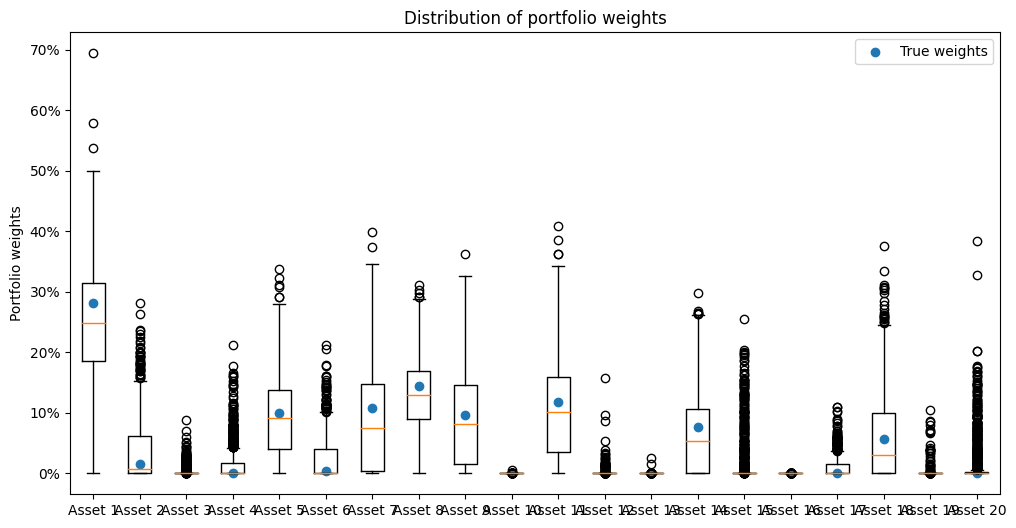

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.boxplot(opt_port_weights);

ax.set_xticklabels(["Asset {}".format(_) for _ in range(1, 21)])
ax.scatter(np.arange(1, 21), w_opt, label="True weights")

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

ax.legend();
ax.set_ylabel("Portfolio weights")
ax.set_title("Distribution of portfolio weights");